<a target="_blank" href="https://colab.research.google.com/github/dahenderson98/K-Means-Clustering/blob/main/Clustering_Lab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Unsupervised Learning: Clustering Lab





In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff

## 1. Implement the HAC and K-means algorithms
For both algorithms:
- Use euclidean distance as the distance metric
- You only need to handle continuous features, but think about how you would handle nominal and unknown data
---
When reporting the results of each algorithm, include the following:
- The number of clusters (*k*)
- The silhouette score of the full clustering (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)

For each cluster include:
- The vectors of points representing the cluster centroid
- The number of instances tied to that centroid
---

### 1.1 HAC (Hierarchical Agglomerative Clustering)

### HAC Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from *n* to 1.  To reduce the amount of output implement a mechanism to specify for which *k* values actual output will be generated.

In [ ]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3, low_print_k=-1, link_type='single', normalize=True):
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.k = k
        self.low_print_k = k if low_print_k == -1 else low_print_k
        self.link_type = link_type
        self.normalize = normalize
        self.dist_matrix = []
        self.clusters = None
        self.k_vals = []
        self.s_scores = []
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """

        # Normalize data unless specified not to
        data = self.normalize_data(X) if self.normalize else X

        # Initialize distance matrix
        self.create_dist_matrix(data)

        # Create cluster (set) for each datapoint
        clusters = []
        for i in range(data.shape[0]):
          clusters.append(set({i}))
        
        # Combine clusters until only 1 cluster remains
        while len(clusters) > 1:
          # Find 2 nearest clusters to be merged
          c1, c2, shortest_dist = -1, -1, float('inf')
          for i in range(len(clusters)-1):
            for j in range(i+1,len(clusters)):
              # Get distance between cluster i and cluster j
              pair_dist = float('inf')
              # Single linking compares clusters by their shortest distance from each other
              if self.link_type == 'single':
                _shortest = float('inf')
                for id1, val1 in enumerate(clusters[i]):
                  for id2, val2 in enumerate(clusters[j]):
                    if self.dist_matrix[val1,val2] < _shortest:
                      pair_dist, _shortest = self.dist_matrix[val1,val2], self.dist_matrix[val1,val2]
              # Complete linking compares clusters by their greatest distance from each other
              elif self.link_type == 'complete':
                _largest = -1
                for id1, val1 in enumerate(clusters[i]):
                  for id2, val2 in enumerate(clusters[j]):
                    if self.dist_matrix[val1,val2] > _largest:
                      pair_dist, _largest = self.dist_matrix[val1,val2], self.dist_matrix[val1,val2]
              # Update min distance if clusters i and j are closer together than previous min
              if pair_dist < shortest_dist:
                c1, c2, shortest_dist = i, j, pair_dist
          # Combine 2 nearest clusters
          assert c1 != -1
          assert c2 != -1
          temp = clusters[c2]
          del clusters[c2]
          clusters[c1] = clusters[c1].union(temp)

          # Produce output if we've reached k clusters
          if (len(clusters) >= self.low_print_k and len(clusters) <= self.k):
            self.clusters = clusters
            # Calculate centroids for all clusters
              # Also compose list of labels for all data points to be used for silhouette scoring
            centroids = []
            _labels = np.zeros(data.shape[0])
            for i in range(len(clusters)):
              sum = np.zeros(data.shape[1])
              for id, val in enumerate(self.clusters[i]):
                sum += data[val,:]
                _labels[val] = i
              centroids.append(sum / len(self.clusters[i]))
            self.centroids = centroids
            
            # Calculate silhouette score for clustering
            self.silhouette_score = silhouette_score(X=data, labels=_labels)
            self.k_vals.append(len(clusters))
            self.s_scores.append(self.silhouette_score)
            # Print final results
            self.print_clusters(len(clusters))
        
        return self

    def create_dist_matrix(self, X):
      self.dist_matrix = np.zeros((X.shape[0],X.shape[0]))
      for x in range(X.shape[0]):
        for y in range(x,X.shape[0]):
          self.dist_matrix[x,y] = np.linalg.norm(X[x,:] - X[y,:])
          self.dist_matrix[y,x] = self.dist_matrix[x,y]

      pass

    def normalize_data(self, X):
      X_new = X.astype(float)
      mins, maxes = X_new.min(axis=0), X_new.max(axis=0)
      return (X_new - mins) / (maxes - mins)
    
    def print_clusters(self, n_clusters):
        print(f"Num clusters: {n_clusters}\n")
        print("Silhouette score: {:.4f}\n\n".format(self.silhouette_score))
        for i in range(n_clusters):
            print(np.array2string(self.centroids[i],precision=4,separator=","))
            print(f"{len(self.clusters[i])}\n")
        
        pass

### 1.1.1 (15%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points are commented out.

- Include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit normalization, else you will not get the same answers as us.
- Report results for *k* = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [ ]:
# Import debug data
!curl -o debug_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"
X_debug = np.array(arff.loadarff('debug_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0  3913k      0 --:--:-- --:--:-- --:--:-- 3913k


In [ ]:
# Single
HAC_single = HACClustering(k=5, link_type='single')
_ = HAC_single.fit(X_debug)

Num clusters: 5

Silhouette score: 0.3453


[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1



In [ ]:
# Complete
HAC_debug_complete = HACClustering(k=5, link_type='complete')
_ = HAC_debug_complete.fit(X_debug)

Num clusters: 5

Silhouette score: 0.3095


[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8



Discussion

I was very grateful that the debug dataset was trimmed down in size, as running my algorithm on the entire dataset may have taken a very long time to complete. It was quite surprising to me that the complete-linkage style yielded a lower silhouette score than the single-linkage style. 

### 1.1.2 (15%) Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

#### Complete Link

In [ ]:
# Load evaluation data
!curl -o eval_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"
X_eval = np.array(arff.loadarff('eval_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  64565      0 --:--:-- --:--:-- --:--:-- 64565


In [ ]:
# Train on evaluation data using complete link
# Print clusters
HAC_eval_complete = HACClustering(k=5, link_type='complete')
_ = HAC_eval_complete.fit(X_eval)

Num clusters: 5

Silhouette score: 0.2930


[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21



#### Single Link

In [ ]:
# Train on evaluation data using single link
# Print clusters
HAC_eval_single = HACClustering(k=5, link_type='single')
_ = HAC_eval_single.fit(X_eval)

Num clusters: 5

Silhouette score: 0.3971


[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70



Discussion

Again, I was quite surprised to see the single-linkage style yielding a higher silhouette score than the complete-linkage style. I was under the impression that, due to single linking's tendency to chain together clusters that are quite far from one another, complete linking would almost always yield higher silhouette scores.

### 1.2 K-means

### Code requirements 
- Ability to choose *k* and specify the *k* initial centroids
- Ability to handle distance ties--when a node or cluster has the same distance to another cluster, which should be rare, choose the earliest cluster in your list

In [ ]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False,print_output=True): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.print_output = print_output

    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # Normalize data
        X_norm = self.normalize_data(X)

        # Generate k initial centroids
        if self.debug: centroids = X_norm[:self.k,:]
        else: centroids = self.get_random_centroids(X_norm)

        # Update centroids while their locations continue to change
        old_centroids = np.zeros(centroids.shape)
        lables = []
        while not self.should_stop(old_centroids, centroids):
          # Save old centroids for convergence test. Book keeping.
          old_centroids = centroids
          
          # Assign labels to each datapoint based on centroids
          labels = self.get_labels(X_norm, centroids)
          
          # Assign centroids based on datapoint labels
          centroids = self.get_centroids(X_norm, labels)

        # Record final centroids and labels
        self.centroids = centroids
        self.labels = labels


        # Calculate silhouette score for clustering
        self.silhouette_score = silhouette_score(X=X_norm, labels=labels)

        # Print final results
        if self.print_output: self.print_clusters()

        return self

    def normalize_data(self, X):
        X_new = X.astype(float)
        mins, maxes = X_new.min(axis=0), X_new.max(axis=0)
        return (X_new - mins) / (maxes - mins)

    def get_random_centroids(self, X):
        # Get min, max for each feature across dataset
        mins, maxes = X.min(axis=0), X.max(axis=0)

        # Create k clusters with random values for each of dataset's features
        centroids = []
        for i in range(self.k):
          c = np.array( [ np.array( np.random.uniform(low=mins[j], high=maxes[j]) ) for j in range(X.shape[1]) ] )
          centroids.append(c)
        
        # Return numpy array of random centroids
        return np.array(centroids)

    # Determine if the algorithm should stop iterating (centroids have not changed)
    def should_stop(self, oldCentroids, centroids):
        unchanged = True
        for i in range(oldCentroids.shape[0]):
          for j in range(oldCentroids.shape[1]):
            if oldCentroids[i,j] != centroids[i,j]: unchanged = False
        return unchanged

    # Returns a label for each piece of data in the dataset. 
    def get_labels(self, X, centroids):
        # For each element in the dataset, chose the closest centroid. 
        # Make that centroid the element's label.

        labels = []

        # Iterate over all instances of dataset, assigning them to whichever centroid (cluster) they are nearest to
        for i in range(X.shape[0]):
          label = 0
          shortest_dist = np.linalg.norm(X[i] - centroids[0])
          for j in range(1,centroids.shape[0]):
            dist = np.linalg.norm(X[i] - centroids[j])
            if dist < shortest_dist:
              label = j
              shortest_dist = dist
          labels.append(label)

        return np.array(labels)

    # Returns k recalculated centroids based on mean of labeled instances from dataset.
    def get_centroids(self, X, labels):
        # Each centroid is the geometric mean of the points that
        # have that centroid's label. Important: If a centroid is empty (no points have
        # that centroid's label) you should randomly re-initialize it.
        new_centroids = []

        # Iterate over all distinct labels (there are k of them)
        for i in range(self.k):
          sum_array, count = np.zeros(X.shape[1]), 0
          # Iterate over all instances in dataset, sum across all instances with label matching i for each feature individually
          # Keep count of instances with label matching i
          for j in range(X.shape[0]):
            if (labels[j] == i):
              sum_array += X[j]
              count += 1
          # Append new centroid consisting of an array of each feature's sum divided by the count of instances with label matching i
          if count != 0:
            new_centroids.append(sum_array / count)
          else: new_centroids.append( [ ( float('inf') ) for j in range(X.shape[1]) ] )

        return np.array(new_centroids)
    
    def print_clusters(self):
        print(f"Num clusters: {self.k}\n")
        print("Silhouette score: {:.4f}\n\n".format(self.silhouette_score))
        _, cluster_counts = np.unique(ar=self.labels, return_counts=True)
        for i in range(self.k):
            print(np.array2string(self.centroids[i],precision=4,separator=","))
            try: print(f"{cluster_counts[i]}\n")
            except: print(f"{0}\n")
        
        pass

### 1.2.1 (10%) K-Means Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)

- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit nomralization, else you will not get the same answers as us.
- Use *k* = 5
- Use the first *k* instances in the training set as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

---
Solution in file:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [ ]:
# Load debug data
!curl -o km_debug_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"
X_km_debug = np.array(arff.loadarff('km_debug_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0  7827k      0 --:--:-- --:--:-- --:--:-- 7827k


In [ ]:
# Train on debug data
# Print clusters
KM_debug = KMEANSClustering(k=5,debug=True)
_ = KM_debug.fit(X_km_debug)

Num clusters: 5

Silhouette score: 0.3845


[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13



### 1.2.2 (15%) K-Means Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

In [ ]:
# Load evaluation data
!curl -o km_eval_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"
X_km_eval = np.array(arff.loadarff('km_eval_data.arff')[0].tolist())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0   297k      0 --:--:-- --:--:-- --:--:--  297k


In [ ]:
# Train on evaluation data
# Print clusters
KM_eval = KMEANSClustering(k=5,debug=True)
_ = KM_eval.fit(X_km_eval)

Num clusters: 5

Silhouette score: 0.2769


[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48



## 2. Iris Clustering with Both Alogrithms
For both algorithms: 
- Don't include the output label as one of the input features
- Normalize the data
- Show your results for clusterings with *k* = 2-7.  
- Graph the silhouette score for each *k* and discuss your results (i.e. what kind of clusters are being made).
- Load this Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

### 2.1 (10%) Iris Clustering with HAC

- Use single-link and complete link clustering algorithms
---

In [ ]:
# Load Iris dataset
!curl -o iris_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"
X_iris_raw = np.array(arff.loadarff('iris_data.arff')[0].tolist())
X_iris = X_iris_raw[:,:-1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  91280      0 --:--:-- --:--:-- --:--:-- 92407


Num clusters: 7

Silhouette score: 0.1094


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5386,0.3539,0.6544,0.6461]
95

[0.1667,0.2083,0.5932,0.6667]
1

[0.8056,0.6667,0.8644,1.    ]
1

[0.4167,0.3333,0.6949,0.9583]
1

[0.9722,0.75  ,0.9407,0.8333]
2

Num clusters: 6

Silhouette score: 0.1605


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5373,0.3537,0.6548,0.6493]
96

[0.1667,0.2083,0.5932,0.6667]
1

[0.8056,0.6667,0.8644,1.    ]
1

[0.9722,0.75  ,0.9407,0.8333]
2

Num clusters: 5

Silhouette score: 0.2051


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5401,0.357 ,0.657 ,0.6529]
97

[0.1667,0.2083,0.5932,0.6667]
1

[0.9722,0.75  ,0.9407,0.8333]
2

Num clusters: 4

Silhouette score: 0.3883


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5363,0.3554,0.6563,0.6531]
98

[0.9722,0.75  ,0.9407,0.8333]
2

Num clusters: 3

Silhouette score: 0.5309


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.12

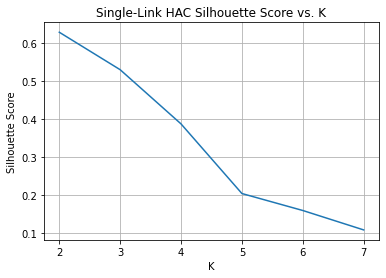

In [ ]:
# Iris Clustering using single-link
iris_single = HACClustering(k=7, low_print_k=2, link_type='single')
_ = iris_single.fit(X_iris)
_ = plt.plot(iris_single.k_vals, iris_single.s_scores)
plt.title("Single-Link HAC Silhouette Score vs. K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid()

Num clusters: 7

Silhouette score: 0.3244


[0.2424,0.6742,0.0827,0.0732]
33

[0.1062,0.4289,0.0708,0.0343]
17

[0.5604,0.4221,0.6094,0.5779]
23

[0.3515,0.2399,0.512 ,0.4741]
29

[0.498 ,0.2768,0.6985,0.7143]
14

[0.6365,0.4601,0.7657,0.8569]
23

[0.8914,0.4735,0.9045,0.8106]
11

Num clusters: 6

Silhouette score: 0.3292


[0.2424,0.6742,0.0827,0.0732]
33

[0.1062,0.4289,0.0708,0.0343]
17

[0.5368,0.3671,0.6432,0.6295]
37

[0.3515,0.2399,0.512 ,0.4741]
29

[0.6365,0.4601,0.7657,0.8569]
23

[0.8914,0.4735,0.9045,0.8106]
11

Num clusters: 5

Silhouette score: 0.3368


[0.2424,0.6742,0.0827,0.0732]
33

[0.1062,0.4289,0.0708,0.0343]
17

[0.5368,0.3671,0.6432,0.6295]
37

[0.3515,0.2399,0.512 ,0.4741]
29

[0.719 ,0.4645,0.8106,0.8419]
34

Num clusters: 4

Silhouette score: 0.3932


[0.2424,0.6742,0.0827,0.0732]
33

[0.1062,0.4289,0.0708,0.0343]
17

[0.4554,0.3112,0.5855,0.5612]
66

[0.719 ,0.4645,0.8106,0.8419]
34

Num clusters: 3

Silhouette score: 0.5031


[0.1961,0.5908,0.0786,0.06  ]
50

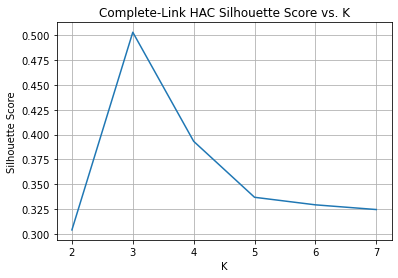

In [ ]:
# Iris Clustering using complete-link
iris_complete = HACClustering(k=7, low_print_k=2, link_type='complete')
_ = iris_complete.fit(X_iris)
_ = plt.plot(iris_complete.k_vals, iris_complete.s_scores)
plt.title("Complete-Link HAC Silhouette Score vs. K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid()

Discuss your results including the differences between single-link and complete-link

Complete link performed far better at clustering the iris datset than single link, as the complete-linkage style created 3 clusters of similar size and we know there are 3 true categories in the dataset. The final silhouette score (k=2) for the single linkage was far higher at 0.6295 than 0.3039 for the final two clusters of complete linkage. Single linkage create long, linear clusters, while complete linkage created more spherical clusters. The highest respective silhouette score for single and complete linkages were achieved at 2 clusters, which is fewer than the known number of true categories. I would have expected the highest silhouette scores to be achieved at 3 clusters, but I was wrong.

### 2.2 (10%) Iris Clustering with K-means

Num clusters: 7

Silhouette score: 0.3444


[0.2326,0.6068,0.0816,0.0807]
16

[0.412 ,0.2769,0.559 ,0.5208]
48

[0.1349,0.4613,0.0751,0.0327]
14

[0.0278,0.3333,0.0466,0.0417]
4

[0.3032,0.8021,0.089 ,0.0729]
12

[0.6677,0.4431,0.7572,0.7821]
52

[0.1111,0.6042,0.0805,0.0521]
4

Num clusters: 6

Silhouette score: 0.3501


[0.2257,0.6146,0.0773,0.0807]
16

[0.412 ,0.2769,0.559 ,0.5208]
48

[0.1358,0.4861,0.08  ,0.037 ]
18

[0.0278,0.3333,0.0466,0.0417]
4

[0.3032,0.8021,0.089 ,0.0729]
12

[0.6677,0.4431,0.7572,0.7821]
52

Num clusters: 5

Silhouette score: 0.3667


[0.6716,0.4404,0.7604,0.7851]
51

[0.4133,0.2832,0.5597,0.523 ]
49

[0.2069,0.5958,0.0788,0.0708]
20

[0.1062,0.4289,0.0708,0.0343]
17

[0.297 ,0.7949,0.0887,0.0769]
13

Num clusters: 4

Silhouette score: 0.4016


[0.7073,0.4509,0.797 ,0.8248]
39

[0.4413,0.3074,0.5757,0.5492]
61

[0.2589,0.6949,0.0823,0.0774]
28

[0.1162,0.4583,0.074 ,0.0379]
22

Num clusters: 3

Silhouette score: 0.5043


[0.7073,0.4509,0.797 ,0.8248]
39

[

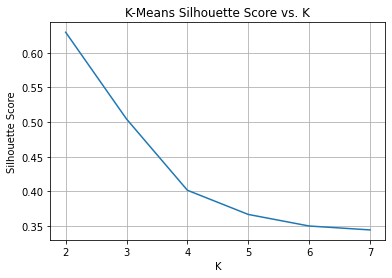

In [ ]:
# Iris Clustering with K-means
k_vals, s_scores = [], []
for i in range(7,1,-1):
  iris_km = KMEANSClustering(k=i,debug=True)
  _ = iris_km.fit(X_iris)
  k_vals.append(i)
  s_scores.append(iris_km.silhouette_score)

_ = plt.plot(k_vals, s_scores)
plt.title("K-Means Silhouette Score vs. K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid()

Discuss your results

Strangely, the greatest silhouette score achieved while running K Means with k values from 7 to 2 occurred at k=2. I would have expected the highest silhouette score to be found at k=3, as there are three known, natural categories in this dataset. The greatest increase in silhouette score occured across the interval k=4 to k=2.

### 2.3 (5%) K-means Initial Centroids Experiment

- Run K-means 5 times with *k*=4, each time with different initial random centroids and discuss any variations in the results.
- If you ever end up with any empty clusters in K-means, re-run with different initial centroids.

In [ ]:
# K-means 5 times

# 1
km_centroids = KMEANSClustering(k=4)
_ = km_centroids.fit(X_iris)

Num clusters: 4

Silhouette score: 0.5043


[0.7073,0.4509,0.797 ,0.8248]
39

[0.1961,0.5908,0.0786,0.06  ]
50

[0.4413,0.3074,0.5757,0.5492]
61

[inf,inf,inf,inf]
0



In [ ]:
# 2
km_centroids = KMEANSClustering(k=4)
_ = km_centroids.fit(X_iris)

Num clusters: 4

Silhouette score: 0.4446


[0.1961,0.5908,0.0786,0.06  ]
50

[0.7385,0.4727,0.8229,0.8635]
29

[0.5417,0.375 ,0.6566,0.6419]
42

[0.3563,0.2371,0.5091,0.4713]
29



In [ ]:
# 3
km_centroids = KMEANSClustering(k=4)
_ = km_centroids.fit(X_iris)

Num clusters: 4

Silhouette score: 0.3890


[0.1559,0.5162,0.0758,0.0544]
36

[0.6677,0.4431,0.7572,0.7821]
52

[0.412 ,0.2769,0.559 ,0.5208]
48

[0.2996,0.7827,0.086 ,0.0744]
14



In [ ]:
# 4
km_centroids = KMEANSClustering(k=4)
_ = km_centroids.fit(X_iris)

Num clusters: 4

Silhouette score: 0.4446


[0.3563,0.2371,0.5091,0.4713]
29

[0.1961,0.5908,0.0786,0.06  ]
50

[0.7385,0.4727,0.8229,0.8635]
29

[0.5417,0.375 ,0.6566,0.6419]
42



In [ ]:
# 5
km_centroids = KMEANSClustering(k=4)
_ = km_centroids.fit(X_iris)

Num clusters: 4

Silhouette score: 0.5043


[0.1961,0.5908,0.0786,0.06  ]
50

[0.4413,0.3074,0.5757,0.5492]
61

[inf,inf,inf,inf]
39

[0.7073,0.4509,0.797 ,0.8248]
0



Discuss any variations in the results

All five trials resulted in silhouette scores very near to the mean (0.4357). Centroids ended up in different spots in all five cases, while the silhouette scores stayed surprisingly consistent. This suggests that the K Means algorithm has approached either a local or an absolute maximum for silhouette score on this dataset.

## 3. Scikit-Learn Comparison

### 3.1 (10%) Run the SK versions of HAC (just complete link) and K-means on Iris data set above

- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [ ]:
skl_HAC = AgglomerativeClustering(n_clusters = 3, affinity="manhattan", linkage="complete")
_ = skl_HAC.fit(X_iris)
print("Clustering Iris Dataset with SKLearn HAC Complete Link\n")
a = silhouette_score(X=X_iris, labels=skl_HAC.labels_)
print("Silhouette (k=3): {:.4f}\n".format(a))
skl_HAC = AgglomerativeClustering(n_clusters = 5, affinity="manhattan", linkage="complete")
_ = skl_HAC.fit(X_iris)
a = silhouette_score(X=X_iris, labels=skl_HAC.labels_)
print("Silhouette (k=5): {:.4f}\n\n\n".format(a))

Clustering Iris Dataset with SKLearn HAC Complete Link

Silhouette (k=3): 0.5541

Silhouette (k=5): 0.4732





/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:976: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X

In [ ]:
skl_km = KMeans(n_clusters=3, init="k-means++", algorithm="elkan")
_ = skl_km.fit(X_iris)
print("Clustering Iris Dataset with SKLearn K Means\n")
a = silhouette_score(X=X_iris, labels=skl_km.labels_)
print("Silhouette (k=3): {:.4f}\n".format(a))
skl_km = KMeans(n_clusters=5, init="k-means++", algorithm="elkan")
_ = skl_km.fit(X_iris)
a = silhouette_score(X=X_iris, labels=skl_km.labels_)
print("Silhouette (k=5): {:.4f}\n\n\n".format(a))

Clustering Iris Dataset with SKLearn K Means

Silhouette (k=3): 0.5526

Silhouette (k=5): 0.4885





/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:976: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:976: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,


*Discuss Results and Comparison with your versions of the algorithms. Discuss effects of different hyperparameters*

The SKLearn HAC algorithm achieved silhouette scores very similar to my HAC algorithm. However, when I switched the distance metric for the SKLearn HAC algorithm from Euclidean distance to Manhattan distance, the silhouette score on the Iris dataset shot up .05 points for k=3, and 0.1 points for k=5. 

For the SKLearn K Means algorithm, the silhouette scores for k=3 and k=5 were nearly identical to the SKLearn HAC algorithm when using Manhattan distance. Switching the init parameter to'k-means++' made no difference on either silhouette score here. Switching the algorithm to 'elkan' left the silhouette score of k=3 the same, but dropped the silhouette score of k=5 by 0.01 point.

### 3.2 (10%) Run the SK version of HAC (just complete link) and K-means on a dataset of your choice 
- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [ ]:
from sklearn import datasets
noisy_moons = datasets.make_moons(n_samples=500, noise=.05)[0]

In [ ]:
skl_HAC = AgglomerativeClustering(n_clusters = 2, affinity="manhattan", linkage="complete")
_ = skl_HAC.fit(noisy_moons)
print("Clustering Noisy Moons Dataset with SKLearn HAC Complete Link\n")
a = silhouette_score(X=noisy_moons, labels=skl_HAC.labels_)
print("Silhouette (k=2): {:.4f}\n".format(a))
skl_HAC = AgglomerativeClustering(n_clusters = 6, affinity="euclidean", linkage="complete")
_ = skl_HAC.fit(noisy_moons)
a = silhouette_score(X=noisy_moons, labels=skl_HAC.labels_)
print("Silhouette (k=6): {:.4f}\n\n\n".format(a))

Clustering Noisy Moons Dataset with SKLearn HAC Complete Link

Silhouette (k=2): 0.4712

Silhouette (k=6): 0.4345





In [ ]:
skl_km = KMeans(n_clusters=2, algorithm="auto")
_ = skl_km.fit(noisy_moons)
print("Clustering Noisy Moons Dataset with SKLearn K Means\n")
a = silhouette_score(X=noisy_moons, labels=skl_km.labels_)
print("Silhouette (k=2): {:.4f}\n".format(a))
skl_km = KMeans(n_clusters=6, algorithm="auto")
_ = skl_km.fit(noisy_moons)
a = silhouette_score(X=noisy_moons, labels=skl_km.labels_)
print("Silhouette (k=6): {:.4f}\n\n\n".format(a))

Clustering Noisy Moons Dataset with SKLearn K Means

Silhouette (k=2): 0.4909

Silhouette (k=6): 0.4977





*Discussion*

On the noisy moons dataset (n=500), SKLearn's K Means algorithm achieved slightly higher (Δ0.0107) a silhouette score than SKLearn's HAC complete link algorithm at k=2, and a much higher silhouette score at k=6 (Δ\~0.12). Swapping the algorithm for K Means to "auto" made no difference in silhouette scores, while switching it to "elkan" decreased both silhouette scores. Changing the affinity property for HAC to "manhattan" decreased silhouette scores slightly (Δ0.029).

## 4. (Optional 5% extra credit) Write your own code for silhouette
If you do this option implement your code for silhouette above in your main implementation and use it for your experiments. Make it clear that the silhouette results come from your code. You may/should compare with the SK version to debug/verify your results.

*Discussion*